In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, MaxPool2D, Conv2DTranspose, concatenate

In [32]:
def split_train_testing(df):
    # Dividing the indexes into train, test, and validation
    train_index, val_index = train_test_split(df.index.values.tolist(), test_size=0.3, random_state=42)
    val_index, test_index = train_test_split(val_index, test_size=0.33, random_state=42)

    # Making train, test, and validation dataframes
    train_df, val_df, test_df = df.iloc[train_index], df.iloc[val_index], df.iloc[test_index]

    return train_df, val_df, test_df

In [39]:
data = pd.read_csv('/Users/anikashrivastava/Desktop/finalproject/labels.csv')
path = '/Users/anikashrivastava/Desktop/finalproject/images'

data['Image Path'] = data['Image Index'].map(lambda x: os.path.join(path, x)) #matching image index with image path

data
filenames = pd.read_csv('/Users/anikashrivastava/Desktop/finalproject/images/filenames.txt', header=None)
filenames.columns = ['Image Index']
filenames

merged_df = pd.merge(data, filenames, on='Image Index', how='inner')
merged_df

pos = merged_df[merged_df["Finding Labels"] == 1] #positive cases
neg = merged_df[merged_df["Finding Labels"] == 0] #negative cases
train, val, test = split_train_testing(merged_df)

print(len(pos))
print(len(neg))

172
4827


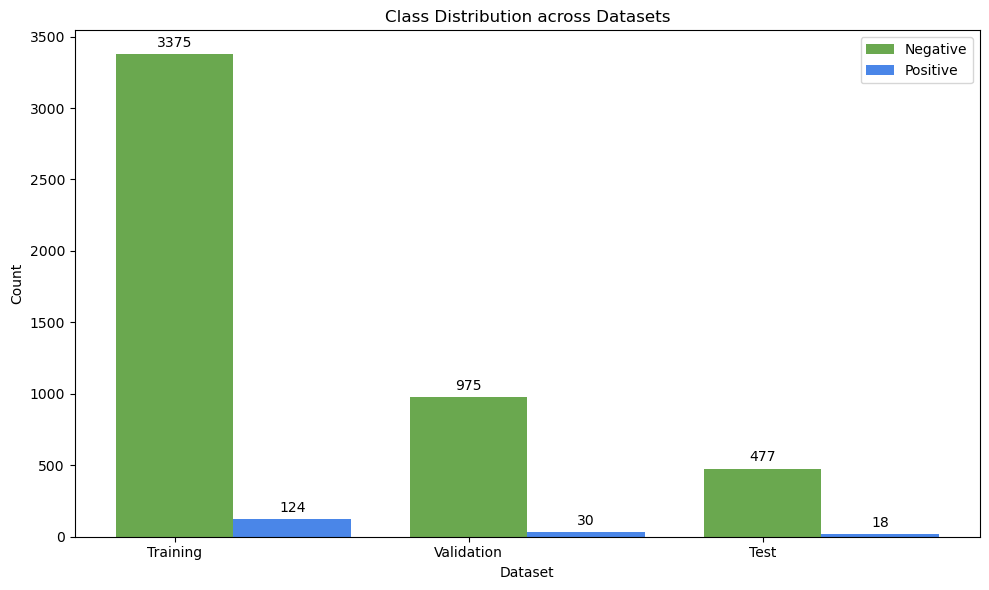

In [40]:
def plot_class_distribution(train_df, val_df, test_df):
    # Counting the class distribution for every dataframe.
    labels = ['Negative', 'Positive']
    colors = ['#6aa84f', '#4a86e8']

    # Extracting counts
    counts = {
        'Training': train_df['Finding Labels'].value_counts(),
        'Validation': val_df['Finding Labels'].value_counts(),
        'Test': test_df['Finding Labels'].value_counts()
    }

    # Setting up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # X axis locations
    x = range(len(counts))
    total_width = 0.8
    single_width = total_width / len(labels)

    # Plotting data
    for i, label in enumerate(labels):
        values = [counts[phase].get(i, 0) for phase in counts]
        bars = ax.bar(x, values, single_width, label=label, color=colors[i])
        x = [xi + single_width for xi in x]  # Shift for the next series

        # Annotating each bar
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Setting the position of bars on X axis
    ax.set_xticks([i + total_width / len(labels) - single_width for i in range(len(counts))])
    ax.set_xticklabels(list(counts.keys()))

    # Adding labels and title
    plt.ylabel('Count')
    plt.xlabel('Dataset')
    plt.title('Class Distribution across Datasets')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()


plot_class_distribution(train, val, test)

In [41]:
def plot_images_and_masks(images, predictions=None, IoU_list=None):
    num_samples = len(images)
    num_rows = 3 if predictions is not None else 2

    fig, axes = plt.subplots(num_rows, num_samples, figsize=(num_samples * 5, num_rows * 5), dpi=100)
    if num_samples == 1:  # If only one sample, axes are not an array
        axes = np.array([[axes]])
    elif num_rows == 1:  # Ensure axes is 2D if only plotting images or masks
        axes = np.array([axes])

    titles = ['Image', 'Mask', 'Prediction']
    for i in range(num_samples):
        items_to_plot = images[i] + ([predictions[i]] if predictions is not None else [])
        for j, item in enumerate(items_to_plot):
            if isinstance(item, str):  # If the item is a file path
                item = Image.open(item)
            axes[j, i].imshow(item, cmap='gray')
            if j == 2 and IoU_list:  # Specific title for predictions with IoU
                title = f'{titles[j]} | IoU: {round(float(IoU_list[i]), 3)}'
            else:
                title = titles[j]
            axes[j, i].set_title(title, fontsize=15, fontweight='bold')
            axes[j, i].axis('off')

    plt.suptitle('Images, Masks, and Predictions', fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

In [42]:
from PIL import Image

def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

pos = train[train['Finding Labels'] == 1]['Image Path'].values[:5]
neg = train[train['Finding Labels'] == 0]['Image Path'].values[:5]

Positive Samples


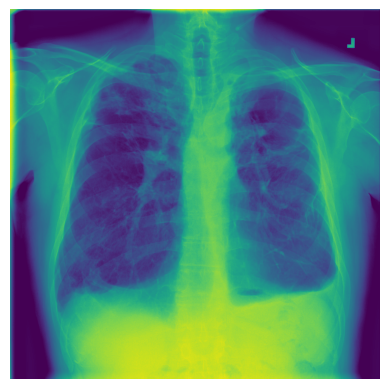

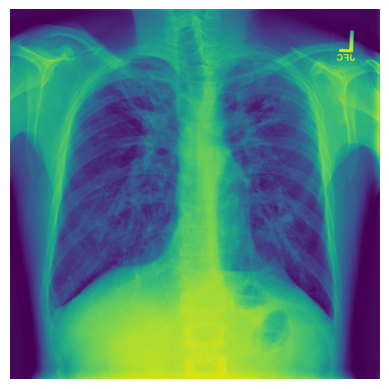

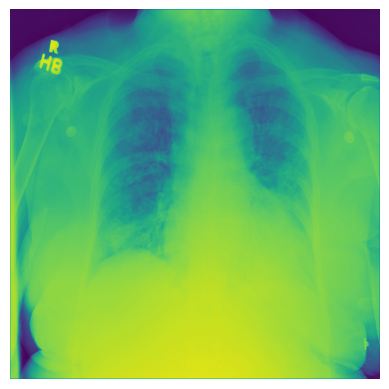

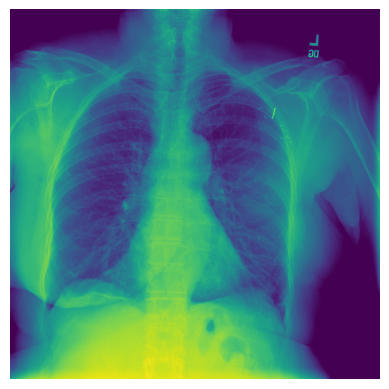

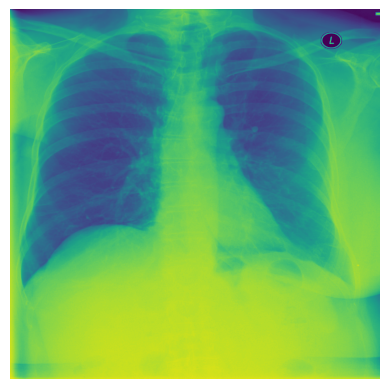

Negative Samples


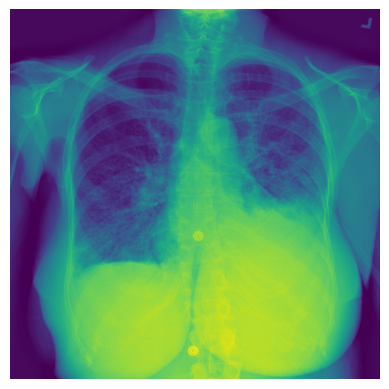

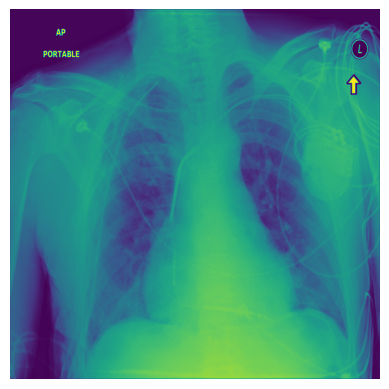

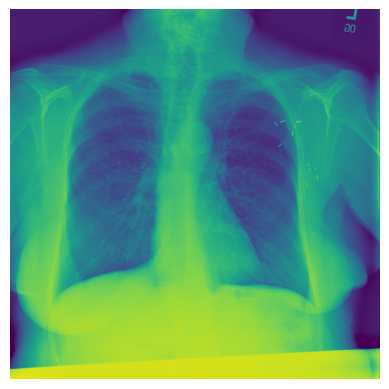

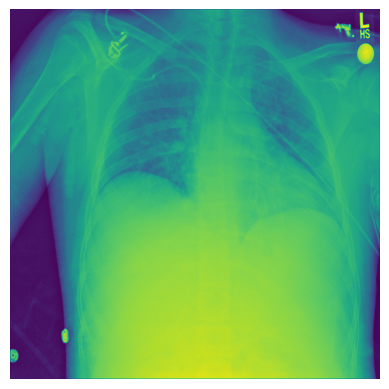

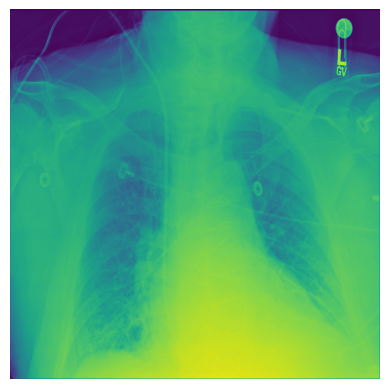

In [43]:
print("Positive Samples")
for i in range(5):
    show_image(pos[i])

print("Negative Samples")
for i in range(5):
    show_image(neg[i])

In [44]:
IMAGE_SIZE = (2500, 2500)
BATCH_SIZE = 64
EPOCHS = 20

def decode_and_resize_image(img_path):
    # Load image from PNG file format.
    #img = tf.io.read_file(img_path)
    #with tf.io.gfile.GFile(img_path, 'rb') as f:
    #    img = Image.open(f)
    #    img = np.array(img)
    #img = tf.convert_to_tensor(img, dtype=tf.float32)
    #print(tf.shape(img))
    #img = tf.image.resize(img, IMAGE_SIZE, preserve_aspect_ratio=True)

    # Scale image pixel values to [0, 1].
    #img = img / 2499.0

    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)  # Specify 3 channels for RGB, 1 for grayscale
    img = tf.image.resize(img, IMAGE_SIZE, preserve_aspect_ratio=True)
    # Normalize the image pixels to [0, 1] assuming they are initially [0, 255]
    img = img / 255.0

    
    return img

In [45]:
def processed_input(img):
    return img

In [46]:
# Constructs a TensorFlow dataset for model training or evaluation.
def make_dataset(images):
    # Creates a dataset of image and mask pairs, applying decoding and resizing.
    dataset = tf.data.Dataset.from_tensor_slices(( 
        list(map(decode_and_resize_image, images))
    ))

    # Randomly shuffles the dataset to ensure model generalization.
    dataset = dataset.shuffle(BATCH_SIZE * 8)

    # Applies formatting to each dataset item to ensure compatibility with the model input.
    dataset = dataset.map(processed_input, num_parallel_calls=tf.data.AUTOTUNE)

    # Organizes data into batches and prefetches them to improve training efficiency.
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

In [47]:
# Prepares training and validation datasets from provided image and mask paths.
train_dataset = make_dataset(list(train['Image Path'].values[0:5]))

validation_dataset = make_dataset(list(val['Image Path'].values))

2024-05-01 18:09:42.136492: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-01 18:09:42.136647: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-01 18:09:42.136663: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-01 18:09:42.137360: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-01 18:09:42.138481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-01 18:10:45.720336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


In [ ]:
def unet(input_size=(256, 256, 3)):
    input = Input(shape=input_size)

    # Encoder
    x = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    output = LeakyReLU(0.2)(x)
    x = MaxPool2D()(output)

    x = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    output2 = LeakyReLU(0.2)(x)
    x = MaxPool2D()(output2)

    #Decoder
    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = concatenate([x, output2], axis=3)
    x = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(64, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = concatenate([x, output], axis=3)
    x = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    final_output = Conv2D(1, 1, padding='same', activation='sigmoid', name='Output')(x)

    model = Model(inputs=input, outputs=final_output)
    model.compile(optimizer=keras.optimizers.Adam(3e-4), loss='mean_squared_error')

    return model